# Optional Lab - Neurons and Layers
In this lab we will explore the inner workings of neurons/units and layers. In particular, the lab will draw parallels to the models you have mastered in Course 1, the regression/linear model and the logistic model. The lab will introduce Tensorflow and demonstrate how these models are implemented in that framework.
<figure>
   <!-- <img src="./images/C2_W1_NeuronsAndLayers.png"  style="width:540px;height:200px;" > -->
   <img src="./images/C2_W1_NeuronsAndLayers.png">
</figure>

## Packages
**Tensorflow and Keras**  
Tensorflow is a machine learning package developed by Google. In 2019, Google integrated Keras into Tensorflow and released Tensorflow 2.0. Keras is a framework developed independently by François Chollet that creates a simple, layer-centric interface to Tensorflow. This course will be using the Keras interface. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras import Sequential
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.activations import sigmoid
from lab_utils_common import dlc
from lab_neurons_utils import plt_prob_1d, sigmoidnp, plt_linear, plt_logistic
import logging
import seaborn as sns

plt.style.use('./deeplearning.mplstyle')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
sns.set_style('whitegrid')

In [2]:
# To avoid: 
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized. 
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Neuron without activation - Regression/Linear Model

### DataSet
We'll use an example from Course 1, linear regression on house prices.

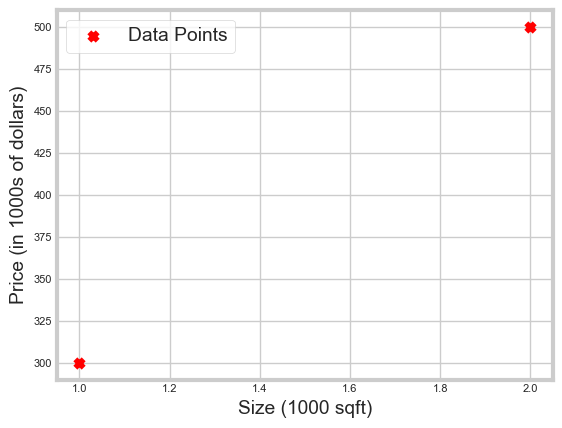

In [3]:
X_train = np.array([[1.0], [2.0]], dtype=np.float32)           #(size in 1000 square feet)
Y_train = np.array([[300.0], [500.0]], dtype=np.float32)       #(price in 1000s of dollars)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_train, Y_train, marker='x', c='r', label="Data Points")
ax.legend(fontsize='xx-large')
ax.set_ylabel('Price (in 1000s of dollars)', fontsize='xx-large')
ax.set_xlabel('Size (1000 sqft)', fontsize='xx-large')
plt.show()

### Regression/Linear Model 
The function implemented by a neuron with no activation is the same as in Course 1, linear regression:
$$ f_{\mathbf{w},b}(x^{(i)}) = \mathbf{w}\cdot x^{(i)} + b \tag{1}$$



We can define a layer with one neuron or unit and compare it to the familiar linear regression function.

In [4]:
linear_layer = tf.keras.layers.Dense(units=1, activation='linear')

Let's examine the weights.

In [5]:
linear_layer.get_weights()

[]

There are no weights as the weights are not yet instantiated. Let's try the model on one example in `X_train`. This will trigger the instantiation of the weights. Note, the input to the layer must be 2-D, so we'll reshape it.

In [7]:
a1 = linear_layer(X_train[0].reshape(1, 1))
print(a1)

tf.Tensor([[-0.47]], shape=(1, 1), dtype=float32)


The result is a tensor (another name for an array) with a shape of (1,1) or one entry.   
Now let's look at the weights and bias. These weights are randomly initialized to small numbers and the bias defaults to being initialized to zero.

In [8]:
w, b = linear_layer.get_weights()
print(f"w = {w}, b = {b}")

w = [[-0.47]], b = [0.]


A linear regression model (1) with a single input feature will have a single weight and bias. This matches the dimensions of our `linear_layer` above.   

The weights are initialized to random values so let's set them to some known values.

In [9]:
set_w = np.array([[200]])
set_b = np.array([100])

# set_weights takes a list of numpy arrays
linear_layer.set_weights([set_w, set_b])
print(linear_layer.get_weights())

[array([[200.]], dtype=float32), array([100.], dtype=float32)]


Let's compare equation (1) to the layer output.

In [10]:
a1 = linear_layer(X_train[0].reshape(1, 1))
print(a1)

alin = np.dot(set_w, X_train[0].reshape(1, 1)) + set_b
print(alin)

tf.Tensor([[300.]], shape=(1, 1), dtype=float32)
[[300.]]


They produce the same values!
Now, we can use our linear layer to make predictions on our training data.

In [11]:
prediction_tf = linear_layer(X_train)
prediction_np = np.dot(X_train, set_w) + set_b

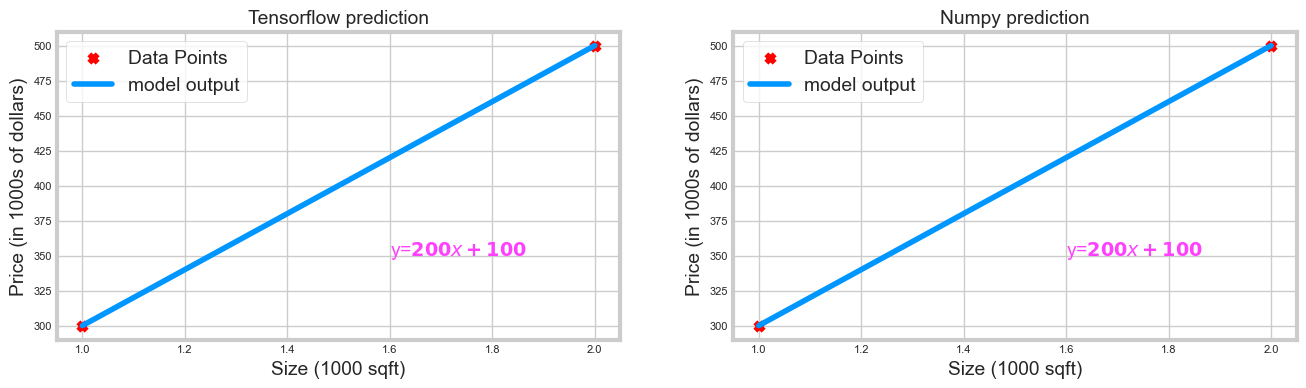

In [12]:
plt_linear(X_train, Y_train, prediction_tf, prediction_np)

## Neuron with Sigmoid activation
The function implemented by a neuron/unit with a sigmoid activation is the same as in Course 1, logistic  regression:
$$ f_{\mathbf{w},b}(x^{(i)}) = g(\mathbf{w}x^{(i)} + b) \tag{2}$$
where $$g(x) = sigmoid(x)$$ 

Let's set $w$ and $b$ to some known values and check the model.


### DataSet
We'll use an example from Course 1, logistic regression.

In [13]:
X_train = np.array([0., 1, 2, 3, 4, 5], dtype=np.float32).reshape(-1, 1)  # 2-D Matrix
Y_train = np.array([0, 0, 0, 1, 1, 1], dtype=np.float32).reshape(-1, 1)  # 2-D Matrix

In [14]:
pos = Y_train == 1
neg = Y_train == 0
X_train[pos]

array([3., 4., 5.], dtype=float32)

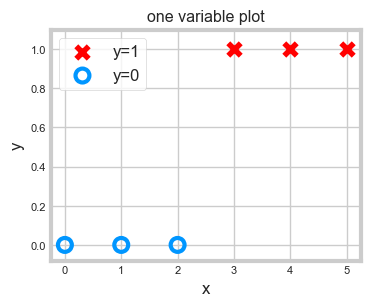

In [15]:
pos = Y_train == 1
neg = Y_train == 0

fig,ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(X_train[pos], Y_train[pos], marker='x', s=80, c='red', label="y=1")
ax.scatter(X_train[neg], Y_train[neg], marker='o', s=100, label="y=0", facecolors='none', 
           edgecolors=dlc["dlblue"], lw=3)

ax.set_ylim(-0.08, 1.1)
ax.set_ylabel('y', fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_title('one variable plot')
ax.legend(fontsize=12)
plt.show()

### Logistic Neuron
We can implement a 'logistic neuron' by adding a sigmoid activation. The function of the neuron is then described by (2) above.   
This section will create a Tensorflow Model that contains our logistic layer to demonstrate an alternate method of creating models. Tensorflow is most often used to create multi-layer models. The [Sequential](https://keras.io/guides/sequential_model/) model is a convenient means of constructing these models.

In [16]:
model = Sequential(
                    [
                        tf.keras.layers.Dense(1, input_dim=1, activation='sigmoid', name='L1')
                    ]
                  )

`model.summary()` shows the layers and number of parameters in the model. There is only one layer in this model and that layer has only one unit. The unit has two parameters, $w$ and $b$.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [18]:
logistic_layer = model.get_layer('L1')
w, b = logistic_layer.get_weights()
print(w, b)
print(w.shape, b.shape)

[[1.22]] [0.]
(1, 1) (1,)


Let's set the weight and bias to some known values.

In [19]:
set_w = np.array([[2]])
set_b = np.array([-4.5])
# set_weights takes a list of numpy arrays
logistic_layer.set_weights([set_w, set_b])
print(logistic_layer.get_weights())

[array([[2.]], dtype=float32), array([-4.5], dtype=float32)]


Let's compare equation (2) to the layer output.

In [20]:
a1 = model.predict(X_train[0].reshape(1, 1))
print(a1)

alog = sigmoidnp(np.dot(set_w, X_train[0].reshape(1, 1)) + set_b)
print(alog)

1/1 [==============================] - 0s 121ms/step
[[0.01]]
[[0.01]]


They produce the same values!
Now, we can use our logistic layer and NumPy model to make predictions on our training data.

1/1 [==============================] - 0s 17ms/step


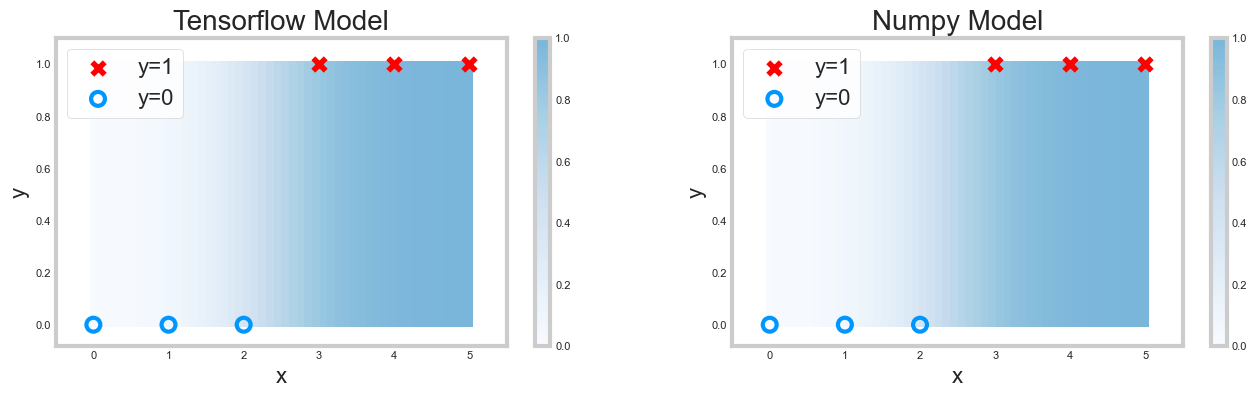

In [21]:
plt_logistic(X_train, Y_train, model, set_w, set_b, pos, neg)

The shading above reflects the output of the sigmoid which varies from 0 to 1.

# Congratulations!
You built a very simple neural network and have explored the similarities of a neuron to the linear and logistic regression from Course 1.